## <center> Forecasting New Home Sales with Google Trends Data </center>

## Background & Overview

Google Trends allows you to search for a particular topic on Google or a specific set of search terms. With it you can see search interest in a topic over time. Search interest is an index of the volume of Google queries by geographic location and category. For instance, we can search for 'Real Estate' within the 'United States'and get search interest dating back several year.

Importantly, the Trends data is not the raw level of queries but a 'query index'. The index starts with the query share: the total query volume for search term in a given geographic region divided by the total number of queries in that region at a point in time.

## Statistical Metholodgy

The goal of this analysis is to predict the current forecast for New Home Sales. US Census Bureau and Department of Housing and Urban Development release statistics on the housing market at the end of each month. In particular, we will be forecasting the New Home Sales figure which is a survey based report that is released on the 3rd week of each month. 

The data we will be using covers the period from 2013-2018 and is seasonally adjusted. This includes ~60 monthly observations of New Home Sales. Given the limited time to complete the project in conjunction with, with the relative 'small' data size I chose to use more straightforward statistical learning methods vs more powerful machine learning algorithms. I will discuss potential extensions and ways to improve in the conclusion.

Thus the implemented model is: **non-seasonal autoregressive model (AR)**

Model: $\log{y_t} = \log{y_{t-1}}+b_{t_{1}}^{k}+b_{t_{2}}^{k}... + e_{t}$

*Where*,

 - $b_{t_{i}}$ is the Google Trends variable 
 - $t$ represents the $t$-th month
 - $k$ represents the $k$-th week of month $t$
 
$e_{t}$ $\approx \mathcal{N}(0,\,\sigma^{2}{I})$


In [ ]:
import preprocessing # preprocessing functions

import statsmodels.formula.api as smf #linear model
import statsmodels.api as sm
import matplotlib.pyplot as plt #plotting/graphics
import seaborn as sns

%matplotlib inline
sns.set()
from IPython.display import display, Latex



We will be using the Google Trends 'Real Estate' search word. This search word is comprised of 8 categories: Apartments & Resisdental Rentals (subcategory ID: 378), Commmerical & Investment Real Estate (1178), Property Developement (687), Property Inspection & Appraisals (463), Property Management (425),Real Estate Agencies (96), Real Estate Listings (1080), Timeshares & Vacaction Property( 1081). [Google Trend Categories](https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories)

Matching categories to the UCB main survey components is one way to choose with subcategories to include in the model. However, in this project we will take pure statistical approach to choosing model parameters via **forward-backward selection** (also known as *step-wise selection*). Further discussed in model selection.

In [454]:
# Included 'Real Estate' subcategories
sub_categories = {
                    378 : "GTrend1", #Apartments & Resisdental Rentals
                    1178: "GTrend2", #Commmerical & Investment Real Estate
                    687 : "GTrend3", #Property Developement
                    463 : "GTrend4", #Property Inspection & Appraisals
                    425 : "GTrend5", #Property Management
                    96  : "GTrend6", #Real Estate Agencies
                    1080: "GTrend7", #Real Estate Listings
                    1081: "GTrend8"  #Timeshares & Vacaction Property
                }

## Data

**get_search_data** function is a helper function that takes the search category i.e. 'Real Estate' and the requested sub_category dictionary then calls the 'Google Trends API' to return a pandas dataframe of weekly search indexes per subcategory

Google Trends search index deviates between 0 and 100. The default frequency of Google Trends data is weekly (daily is optional). The index is somewhat unintutive if one is unfamiliar with Google's metholody in terms of how they compute the normalized, relative indexing. It's worth reading up on the calculation. [Quora: Google Trends](https://www.quora.com/How-do-you-interpret-Google-Trendss-search-volume-index)

Given the data is weekly and New Home Sales report is release in the 3rd month of the calendar our hypothesis is that the 3rd weekly release of the Google Trends search index can be used to predict the New Home Sales index.

In [455]:
search_term = 'real estate'
data = get_search_data(search_term, sub_categories)
data.head(10)

,GTrend1,GTrend2,GTrend3,GTrend4,GTrend5,GTrend6,GTrend7,GTrend8
date,,,,,,,,
2013-05-19,87,72,77,55,64,72,89,65
2013-05-26,91,78,42,69,69,88,98,70
2013-06-02,90,74,59,78,79,86,92,84
2013-06-09,80,75,65,59,83,92,92,66
2013-06-16,93,77,66,64,84,87,92,67
2013-06-23,96,81,61,80,93,85,93,76
2013-06-30,84,70,44,85,62,76,94,78
2013-07-07,96,87,67,66,93,94,96,66
2013-07-14,88,83,48,57,85,99,99,79


## Exploratory Data Analysis (EDA)

We start with a basic description of the dataset using pandas describe() function. Interestingly, we notice that **GTrend8** which is Timeshares & Vacaction Property mean value is ~49. Google Trends index of 50 indicates no relative change. This may indicate that this variable does not have predictive power is the average relative index level is 50.

In [323]:
data.describe()

,GTrend1,GTrend2,GTrend3,GTrend4,GTrend5,GTrend6,GTrend7,GTrend8
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,63.415385,79.092308,65.707692,61.230769,71.865385,76.576923,71.534615,48.880769
std,13.931318,8.414408,10.744090,11.971355,11.079267,11.054002,11.099530,13.821994
min,35.000000,45.000000,41.000000,31.000000,38.000000,41.000000,47.000000,21.000000
25%,53.000000,74.000000,59.000000,53.000000,65.000000,70.000000,64.000000,39.000000
50%,62.000000,79.000000,66.000000,60.000000,72.000000,77.000000,72.000000,46.000000
75%,74.000000,85.000000,73.000000,69.000000,80.000000,85.000000,79.000000,57.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


### Test vs Train Split
 - Use data from 2013/06 to 2017/02 for Training
 - Use data from 2017/03 to 2018/03 for Testing
 - Take the 3rd weekly release of Google Trend data per subcategory

In [221]:
train_start = '2013-01-01'
test_start = '2017-01-01'
week_num = 3

train, test = test_train_split(data, train_start, test_start)
train = extract_weekly_trend(train, week_num)
test = extract_weekly_trend(test, week_num)

Next we plot the data. Notice the large spikes/drops in interest in categories like Real Estate Agencies, Property inspection and Appraisals, etc. These percent increases in a search topic can be useful to understand how much rise in interest there is in a topic. Increases are based on a topic’s growth in search interest over a distinct period of time compared to the previous period. Hence they may reflect going on in the region of interest. We again note that Timeshares has been below 50 since late 2016. 

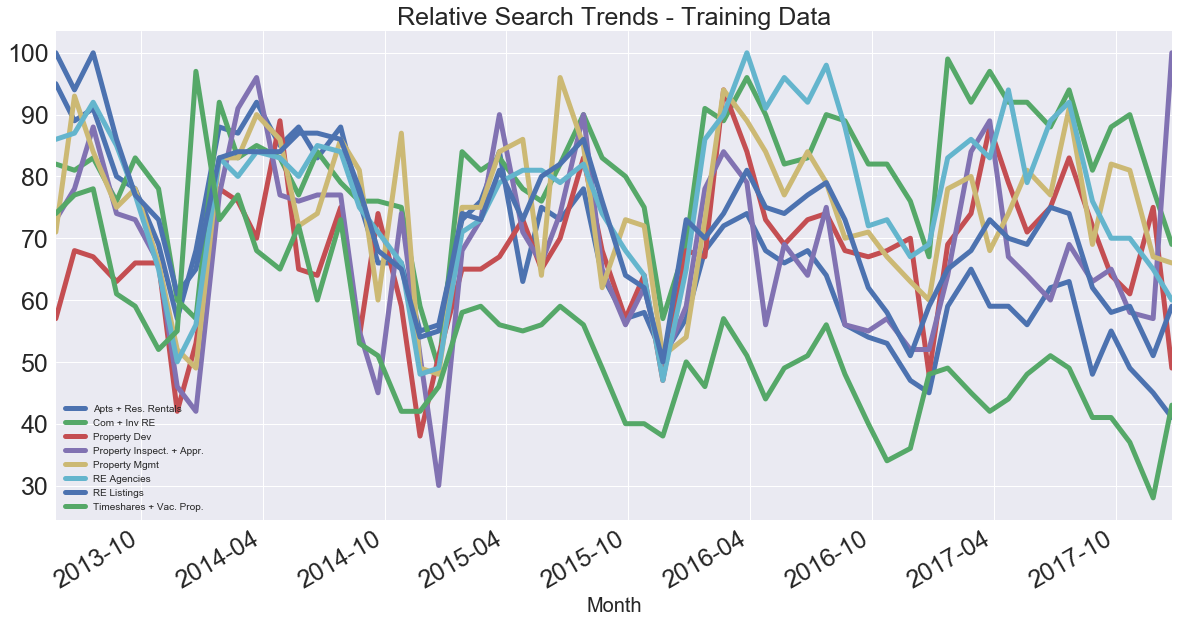

In [121]:
train.plot(figsize=(20,10), linewidth=5, fontsize=25)
plt.title('Relative Search Trends - Training Data', fontsize=25);
plt.xlabel('Month', fontsize=20);

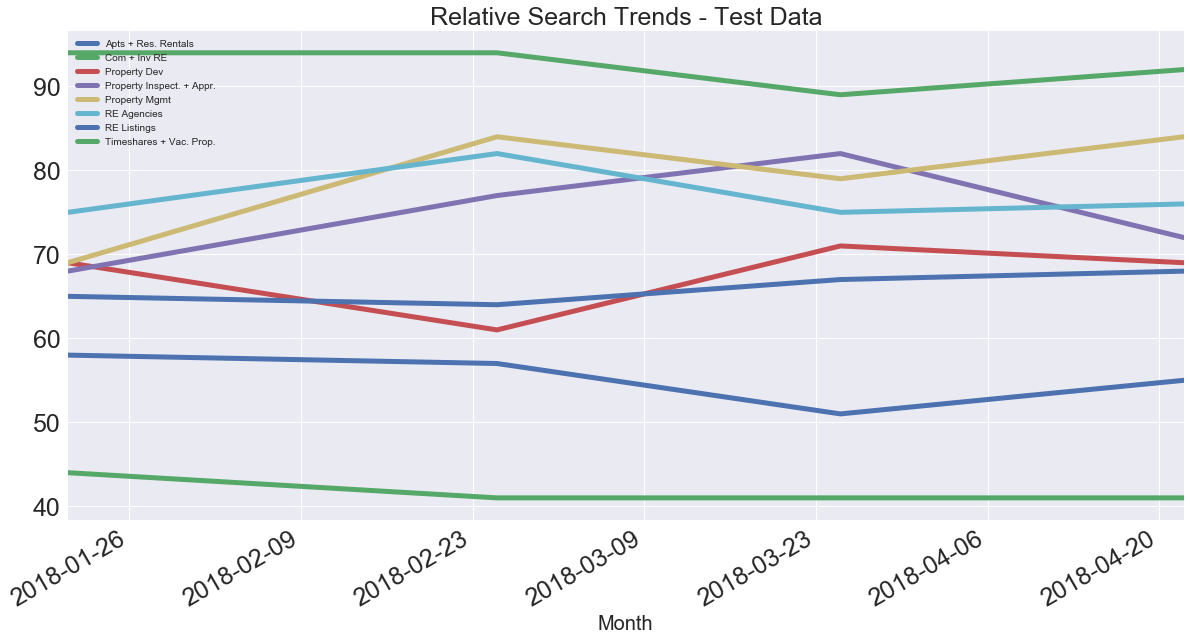

In [122]:
test.plot(figsize=(20,10), linewidth=5, fontsize=25)
plt.title('Relative Search Trends - Test Data', fontsize=25);
plt.xlabel('Month', fontsize=20);

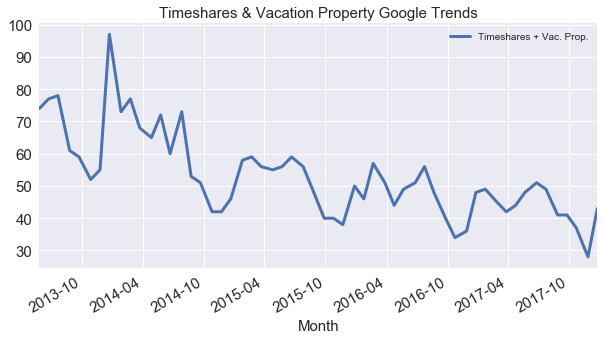

In [123]:
train[['Timeshares + Vac. Prop.']].plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.title('Timeshares & Vacation Property Google Trends', fontsize=15);
plt.xlabel('Month', fontsize=15);

In [196]:
# Data URL: https://goo.gl/QjjhNi
fileName = 'home_sales_data_SA.csv'
home_sales_df = get_home_sales_data(fileName)


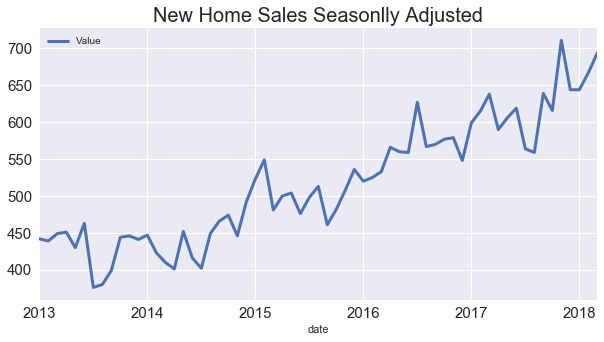

In [197]:
home_sales_df.plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.title('New Home Sales Seasonlly Adjusted', fontsize=20);


## Model Selection

### Partial Autocorrelation

Partial autocorrelation (PACF) gives the partial correlation of the time series with its own lagged values, controlling for the values of the time series at all shorter lags. They a commonly used in auto regressive models such as these. 

We look for statistically significant (%5) lag levels. Below we see that up to lag 2 is significant hence indicating that we may want to include up to lag 2 in our model.

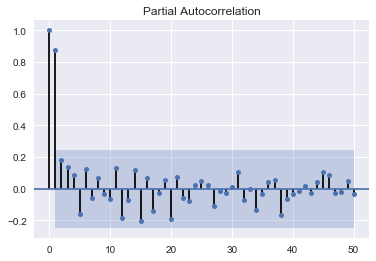

In [205]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(np.log(home_sales_df['Value']), lags=50)
plt.show()

**Preprocess_data** is the main preprocessing method as the name suggests. Essentially it constructs our entire training/ testing datasets. 

Specifically:
 - Creates lag 1 & 2 variables (log)
 - Segements the Google Trend data by specific week (default 3rd week of month)
 - Splits data into Train and Test
 - Adds response variable 'Value' to each dataframe

In [324]:
y_raw = get_home_sales_data(fileName)
raw_search_data = get_search_data(search_term, sub_categories)

train_data, test_data = preprocess_data(y_raw, raw_search_data, train_start, test_start)

In [464]:
# Snap shot
test_data.head(20)

,lag1,lag2,GTrend1,GTrend2,GTrend3,GTrend4,GTrend5,GTrend6,GTrend7,GTrend8,Value
date,,,,,,,,,,,
2017-03,6.421622,6.395262,48,89,66,71,72,81,72,38,6.458338
2017-04,6.458338,6.421622,60,80,80,57,77,88,72,42,6.380123
2017-05,6.380123,6.458338,50,87,75,54,67,78,70,38,6.406880
2017-06,6.406880,6.380123,55,90,81,43,78,85,72,42,6.428105
2017-07,6.428105,6.406880,64,88,75,64,80,90,73,48,6.335054
2017-08,6.335054,6.428105,46,78,67,66,71,71,65,40,6.326149
2017-09,6.326149,6.335054,50,79,82,56,75,74,59,36,6.459904
2017-10,6.459904,6.326149,38,83,68,56,72,69,59,34,6.423247
2017-11,6.423247,6.459904,35,69,74,61,73,64,50,24,6.566672


### Forward Selection vs Forward-Backward Selection

Python's Statsmodels interestingly enough does not have a built-in stepwise function for linear models; the same applied to SciKit-Learn. The canonical example would be R's AIC function for linear models which uses Akaike information criterion to choose model parameters. 

Below there are two functions that perform stepwise feature selection. Method one **forward_selected** is a implemention of only forward-selection where we add features to the model based on $R^{2}$. Method two **step-wise selection** which uses for model p-value to incrementally select features that are statistically impactful on model. It is my prefered method

A few things to point out. Both these approachs are beholden to the traditional linear least squares assumptions. Inherently, if a feature is additive to the model based on it's OLS p-value for instance then we are assuming the 'true model' satistifies our regression assumptions.

In [395]:
# source: https://planspace.org/20150423-forward_selection_with_statsmodels/
def forward_selected(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    included = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(included + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            included.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {}".format(response,
                                   ' + '.join(included))
    model = smf.ols(formula, data).fit()
    return included, model

def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out = 0.05, verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included



## Analysis

Model_1 is built using stepwise_selection and variables lag1 and GTrend4 prove to be most significant in the model. The adjusted R-sqaured or the % of variability explained by predictors adjusted by model degrees of freedome is 0.745. The coefficient from GTrend4 suggests that everything else held constant the log(New Home Sales) level changes by 1.6% for a 1% change in Property Inspection & Appraisals Google search query index. Durbin-Watson, a test for autocorrelation, is $\approx$ 2 which suggests no or little autocorrelation.

In [444]:
y = train_data['Value']
_ = set(train_data.columns) - set(['Value'])
X = train_data[list(_)]

result = stepwise_selection(X, y)
print('resulting features:', result)
model_1 = smf.ols('Value ~ lag1 + GTrend4', data=train_data).fit()
print(model_1.summary())


Add  lag1                           with p-value 1.77543e-13
Add  GTrend4                        with p-value 0.0343205
resulting features: ['lag1', 'GTrend4']
                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     63.95
Date:                Tue, 15 May 2018   Prob (F-statistic):           2.49e-13
Time:                        18:11:24   Log-Likelihood:                 60.093
No. Observations:                  44   AIC:                            -114.2
Df Residuals:                      41   BIC:                            -108.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P

Model_2 is built using only forward_selection and variables lag1, lag2, GTrend4, GTrend3, GTrend8 are selected based on adjusted r-squared. The model is may have lead to the best r-squared but right off the bat we are skeptical given the high (> %5 significance) of the variables  GTrend3, lag2, GTrend4. Non of these variables are significant in the model. Also interesting is the conditional number doubles from model1 to model2 which is potentially indicative of multicolinarity.  

In [429]:
result, model_2 = forward_selected(train_data, 'Value')

print('resulting features:', result)
print(model_2.summary())

resulting features: ['lag1', 'GTrend4', 'GTrend3', 'lag2', 'GTrend8']
                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     29.70
Date:                Tue, 15 May 2018   Prob (F-statistic):           3.71e-12
Time:                        18:03:36   Log-Likelihood:                 63.943
No. Observations:                  44   AIC:                            -115.9
Df Residuals:                      38   BIC:                            -105.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [418]:
def calc_monthly_mae(y_pred, y_true):
    return np.abs(y_pred-y_true)

In [427]:
y_pred_1 = model_1.predict(test_data)
y_pred_2 = model_2.predict(test_data)
y_pred_3 = smf.ols('Value ~ lag1', data=train_data).fit().predict(test_data) #base-case model
y_true = test_data['Value']

errors = pd.DataFrame()
errors['model_1'] = calc_monthy_mae(y_pred_1, y_true)
errors['model_2'] = calc_monthy_mae(y_pred_2, y_true)
errors['model_3'] = calc_monthy_mae(y_pred_3, y_true)

print("Model 1 Mean Absolute Error: ", sum(errors['model_1'])/len(errors['model_1']))
print("Model 2 Mean Absolute Error: ", sum(errors['model_2'])/len(errors['model_2']))
print("Model 3 Mean Absolute Error: ", sum(errors['model_3'])/len(errors['model_3']))

Model 1 Mean Absolute Error:  0.0682256729156
Model 2 Mean Absolute Error:  0.0617110704178
Model 3 Mean Absolute Error:  0.0648387573629


### Dianogstics

#### Monthly Prediction Error per Model

Model_3 is used to serve as a baseline and includes only the lag1 variable. We see from the error bar plot for each monthly prediction below all models are rather optimistic in their prediction for the New Home Sales level. On average all models have a absolute mean error of $\approx$ 6%. The largest error comes from September 2017 and November 2017. It would be worthwhile to dig into the search query or news to see what is leading to this dramatic change in prediction. Model_3 performs relatively poorly in the beginning of 2017 before outperforming other models in the later half of 2017 and early 2018. On average model_2 appears to the best throughout 2017 into 2018. This is a manifestation of model_2 capturing more variability (a la 'higher' adjusted r-squared). 



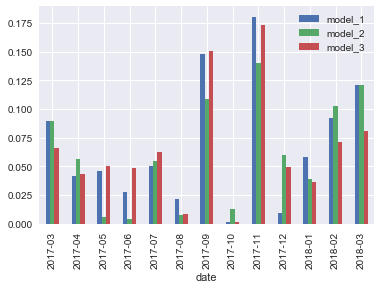

In [428]:
mae_errors.plot.bar()

### QQPlots & Influential Points

The qqplots appear normal. Notice the outliers on both residual plots. These points are picked up in influence_plot using Cook's Distance as the eval measurement. It would be worth while to investigate these points
further

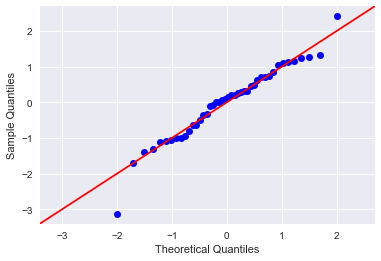

In [440]:
res = model_1.resid # residuals
fig = sm.qqplot(res, fit=True, line='45')
plt.show()

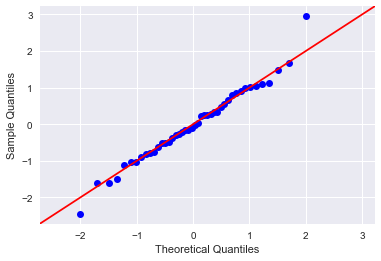

In [439]:
res = model_2.resid # residuals
fig = sm.qqplot(res, fit=True, line='45')
plt.show()

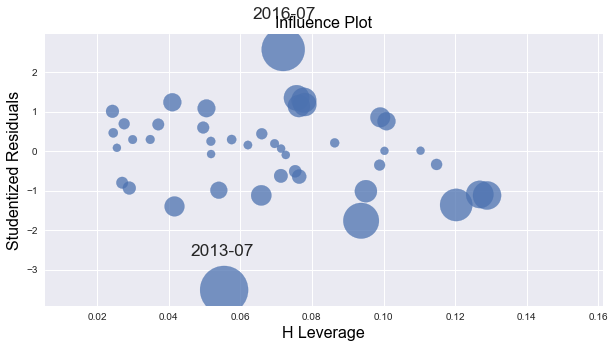

In [451]:
fig, ax = plt.subplots(figsize=(10,5))
fig = sm.graphics.influence_plot(model_1, ax=ax, criterion="cooks")

## Conclusion & Future Work

In the project we show a straight-forward method for predicting the economic indicator New Home Sales using open-sourced alternative data from Google Search Trends. Specifically we modeled New Home Sales as a autoregressive model of lag one with additionally predictors from the eight 'Real Estate' search sub-categories.

Future work would be explore using diffierent or combination of Google Search query index information as opposed to somewhat arbitrarily using the 3rd week's query level to see the effect on the model. Additionally, we should explore more powerful algorithm such as SVM regression, lasso/ridge regression (vs step-wise selection), and possibly ensemble methods. Furthermore, Google Trend data dates back to 2004.

Other things to try after increasing the data beyond 2013, would be to reframe the problem potentially as binary or even multi-class classification problem to predict the change in New Home Sales i.e. ('unched', '+/-5', '> or < 10') vs the absolute level. From here we may be able explore shallow nueral nets like CNNs or better LSTMs once we have more data and simply the problem.